# **Pytorch: Image Segmentation using Pre-Trained Models**

------------------



## Importing Necessary Libraries and Frameworks

In [ ]:
import torch
import torchvision
import gc

## Importing Test Images

Downloading three images for Semantic Image Segmentation task.

In [ ]:
%%capture
!wget https://www.luxurytravelmagazine.com/files/593/2/80152/luxury-travel-instagram_bu.jpg
!wget https://www.akc.org/wp-content/uploads/2020/12/training-behavior.jpg
!wget https://images.squarespace-cdn.com/content/v1/519bd105e4b0c8ea540e7b36/1555002210238-V3YQS9DEYD2QLV6UODKL/The-Benefits-Of-Playing-Outside-For-Children.jpg

Checking for proper download

In [ ]:
%ls

luxury-travel-instagram_bu.jpg  The-Benefits-Of-Playing-Outside-For-Children.jpg
sample_data/                    training-behavior.jpg


 Load Images in Memory using Pillow Library

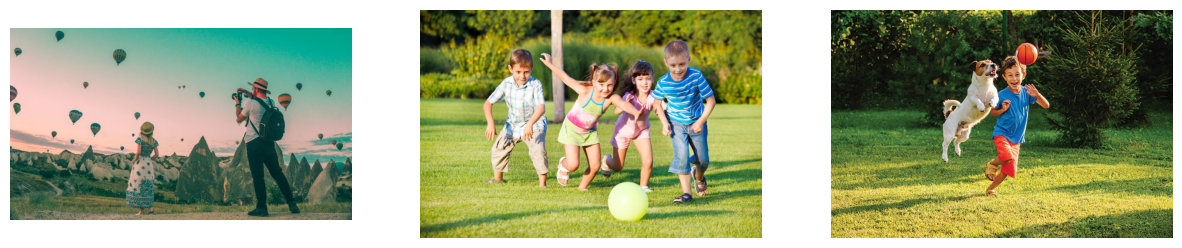

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

holiday = Image.open('luxury-travel-instagram_bu.jpg')
dog_kid_playing = Image.open('training-behavior.jpg')
kids_playing = Image.open('The-Benefits-Of-Playing-Outside-For-Children.jpg')
# Create a list of images
images = [holiday, kids_playing, dog_kid_playing]

# Create a figure and axis with a grid of 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display each image in the grid
for ax, img in zip(axs, images):
    ax.imshow(img)
    ax.axis('off')  # Hide the axes

# Show the plot
plt.show()

These images downloaded from web contains objects like people, dogs, toys etc. that we can try to detect using image segmentation.

## Image to Tensors

Convert Pillow Images to PyTorch Tensors

In [ ]:
from torchvision.transforms.functional import pil_to_tensor

holiday_tensor_int = pil_to_tensor(holiday)
kids_playing_tensor_int = pil_to_tensor(kids_playing)
dog_kid_playing_tensor_int = pil_to_tensor(dog_kid_playing)

holiday_tensor_int.shape, kids_playing_tensor_int.shape, dog_kid_playing_tensor_int.shape

(torch.Size([3, 422, 750]),
 torch.Size([3, 667, 1000]),
 torch.Size([3, 486, 729]))

In [ ]:
holiday_tensor_int.dtype

torch.uint8

## Semantic Segmentation Model - DeepLabV3 Model

### Loading the FCN_ResNet50 model for segmentation task.

In [ ]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights
lraspp = lraspp_mobilenet_v3_large(weights=LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)
lraspp.eval();

Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth
100%|██████████| 12.5M/12.5M [00:06<00:00, 2.18MB/s]


### Preprocess Images and Make Predictions

*   For making segmentation predictions on images, we need to preprocess the images and use the previously loaded model for predictions.

*   The weights objects have a method named transforms() which can be used to prepare images for network.

*   By default ,method resizes image to size 520, rescale in the range [0.0, 1.0] and normalize using mean [0.485, 0.456, 0.406] & standard deviation [0.229, 0.224, 0.225].










In [ ]:
preprocess_img = LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms(resize_size=None)

preprocess_img(holiday_tensor_int).unsqueeze(dim=0).shape

torch.Size([1, 3, 422, 750])


*   Next step is to make predictions on network preprocessed images. We have also used batch dimension using unsqueeze() because model works on batch of images.

*   The output of model is a dictionary with two keys: "out" - Detected objects masks and "aux".

*    The out key value stores segmented image which we can be visualize later for result analysis.



In [ ]:
holiday_preds1 = lraspp(preprocess_img(holiday_tensor_int).unsqueeze(dim=0))
gc.collect();

holiday_preds1.keys()

odict_keys(['out'])

In [ ]:
kids_playing_preds1 = lraspp(preprocess_img(kids_playing_tensor_int).unsqueeze(dim=0))
gc.collect();
dog_kid_playing_preds1 = lraspp(preprocess_img(dog_kid_playing_tensor_int).unsqueeze(dim=0))
gc.collect();

We have created a dictionary that maps object names to their index. We'll be using this mapping to retrieve segmentation results for a particular object.

In [ ]:
class_to_idx = {cls: idx for (idx, cls) in enumerate(LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.meta["categories"])}

class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

## Results Visualization

The retrieved predictions made on our holiday image are being stored in a variable. The predictions are present in out key of prediction.

The shape of prediction present in out key is (#class, height, width) where '#class' is a number of objects that model is trained to detect. In our case, it is 20 which we can see from dictionary loaded in previous cell.

After loading prediction, we have normalized masks using softmax() function.

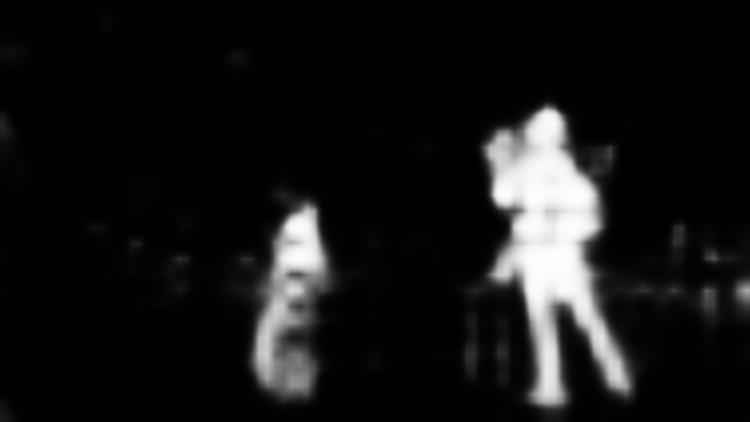

In [ ]:
from torchvision.transforms.functional import to_pil_image

prediction = holiday_preds1['out']
normalized_masks = prediction.softmax(dim=1)[0]

to_pil_image(normalized_masks[class_to_idx['person']])

### draw_segmentation_masks()

This method enables us tooverlay detected objects on original image.

First, we have created a boolean mask from normalized mask by setting condition which sets probabilities above 0.7 to True.

Then, we have called draw_segmentation_masks() method with an original image and person mask to overlay detected person objects on original image.

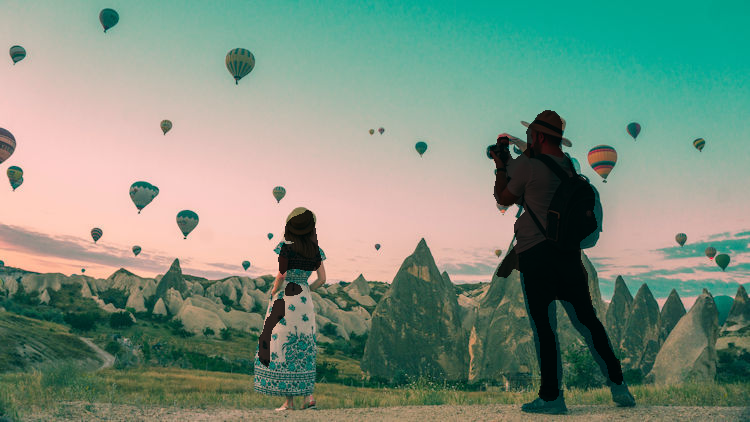

In [ ]:
from torchvision.utils import draw_segmentation_masks

masks = normalized_masks > 0.7

out = draw_segmentation_masks(holiday_tensor_int, masks[class_to_idx['person']])

to_pil_image(out)

Below, we have overlaid background on an original image using same process as previous cell.

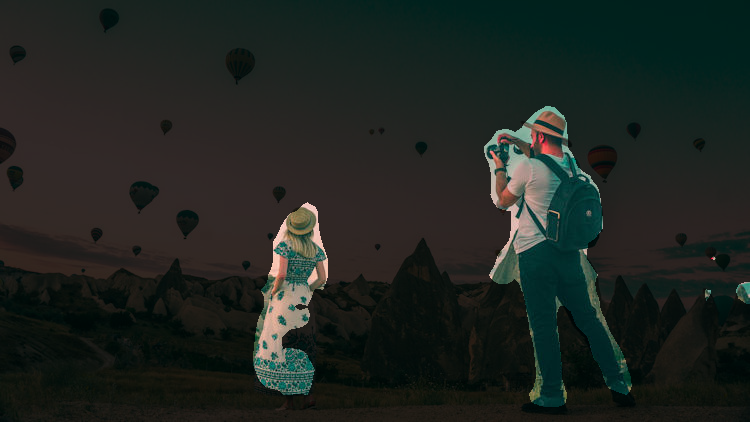

In [ ]:
from torchvision.utils import draw_segmentation_masks

masks = normalized_masks > 0.7

background = draw_segmentation_masks(holiday_tensor_int, masks[class_to_idx['__background__']])

to_pil_image(background)

Below, we have retrieved persons object present in our section image and visualized it. We can notice that model is correctly identifying all kids present in an image.

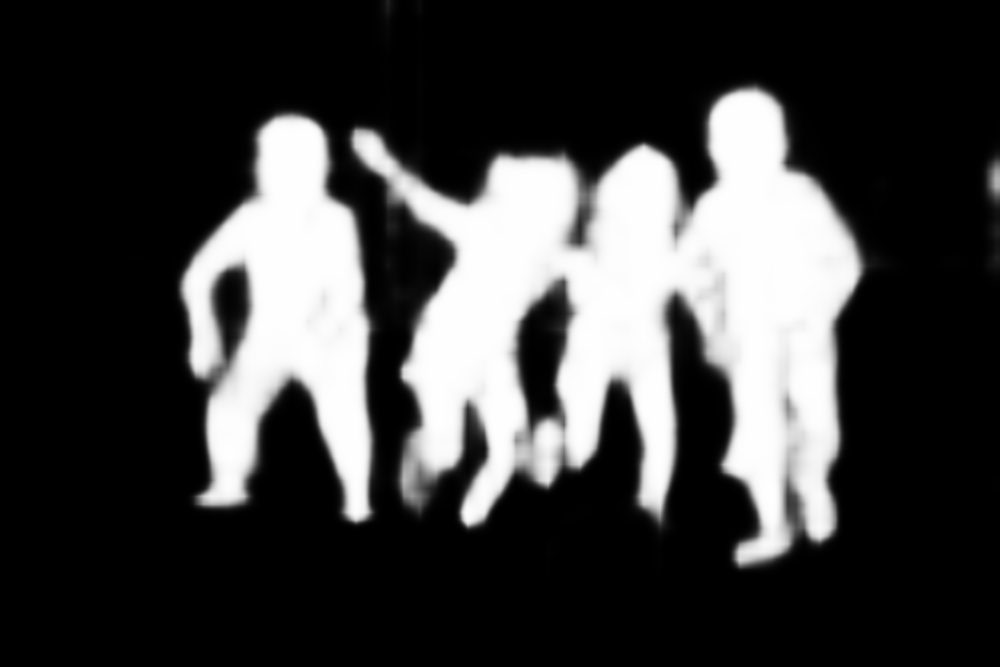

In [ ]:
from torchvision.transforms.functional import to_pil_image

prediction = kids_playing_preds1['out']
normalized_masks = prediction.softmax(dim=1)[0]

to_pil_image(normalized_masks[class_to_idx['person']])

Below, we have overlaid detected kids on original image.

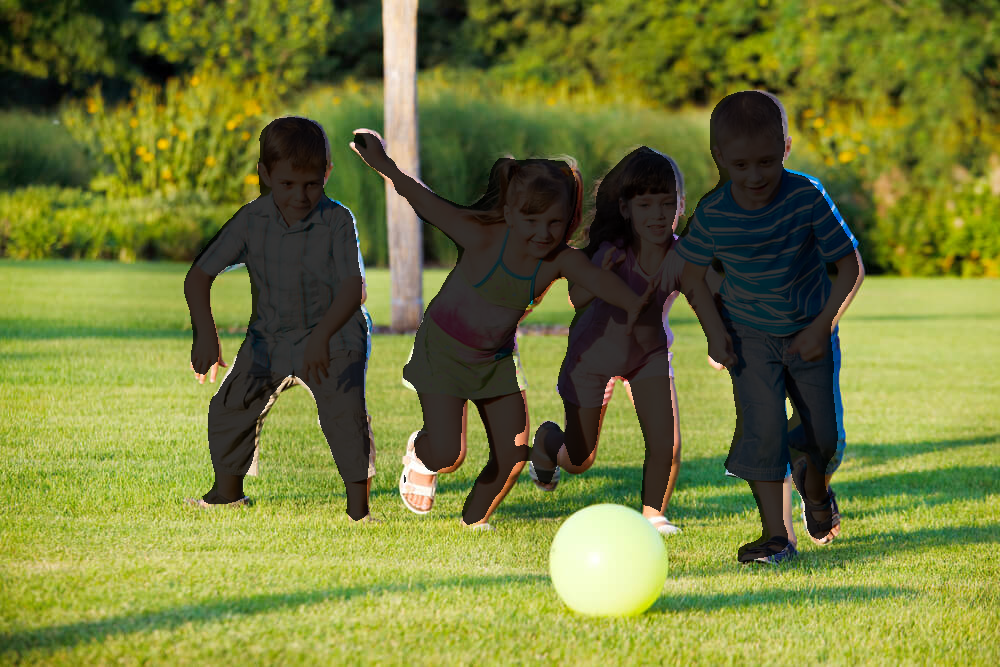

In [ ]:
from torchvision.utils import draw_segmentation_masks

masks = normalized_masks > 0.7

out = draw_segmentation_masks(kids_playing_tensor_int, masks[class_to_idx['person']])

to_pil_image(out)

Below, we have retrieved person object for third image and visualized it.

In the next cell, we have retrieved a dog object from same image and visualized it as well.

On later cells, we have overlaid kid and dog object on original image.

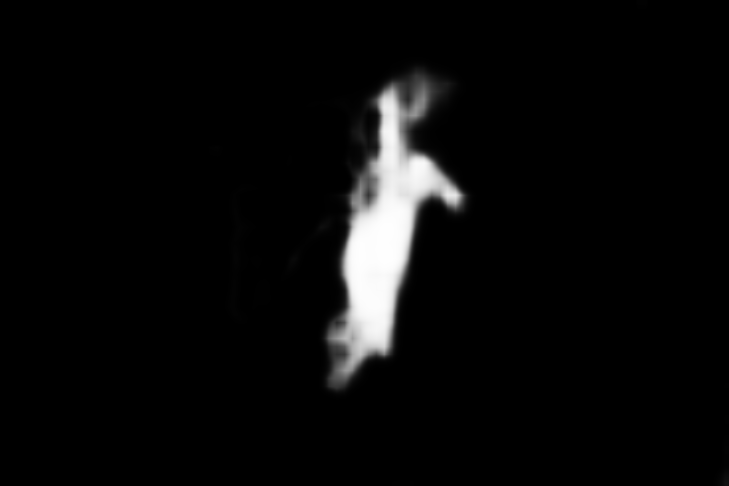

In [ ]:
from torchvision.transforms.functional import to_pil_image

prediction = dog_kid_playing_preds1['out']
normalized_masks = prediction.softmax(dim=1)[0]

to_pil_image(normalized_masks[class_to_idx['person']])

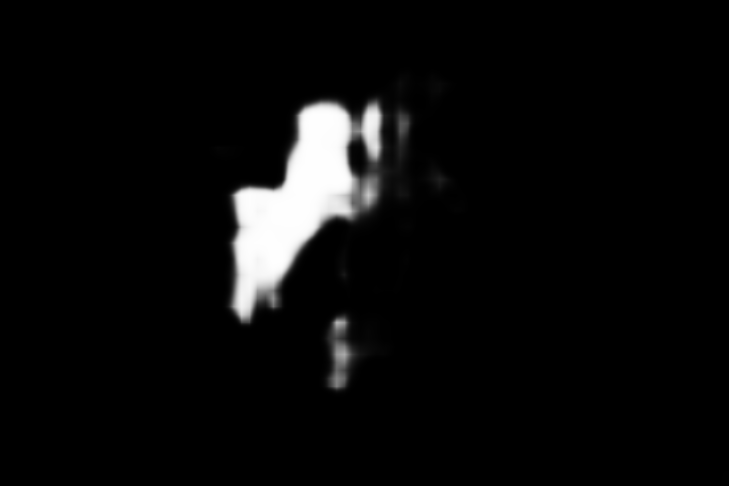

In [ ]:
to_pil_image(normalized_masks[class_to_idx['dog']])

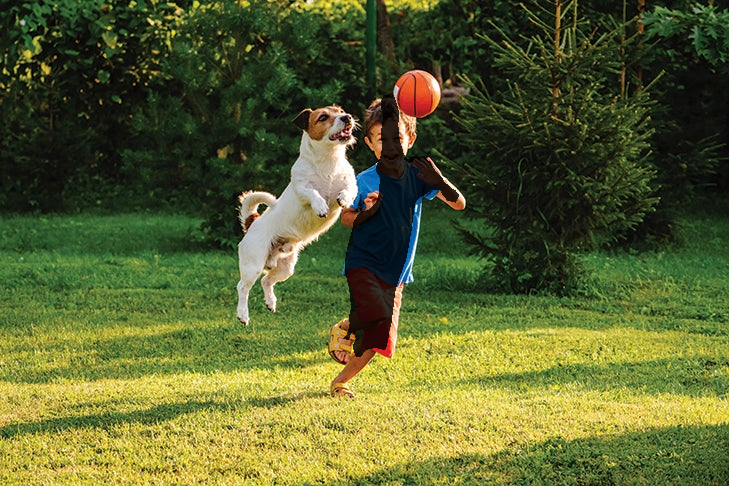

In [ ]:
from torchvision.utils import draw_segmentation_masks

masks = normalized_masks > 0.7

person = draw_segmentation_masks(dog_kid_playing_tensor_int, masks[class_to_idx['person']])

to_pil_image(person)

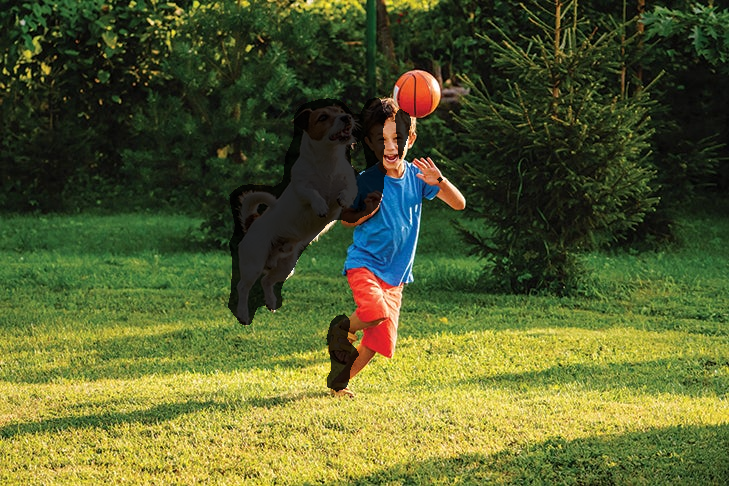

In [ ]:
from torchvision.utils import draw_segmentation_masks

masks = normalized_masks > 0.1

dog = draw_segmentation_masks(dog_kid_playing_tensor_int, masks=masks[class_to_idx['dog']])

to_pil_image(dog)